In [66]:
import glob
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel

%matplotlib inline

## Relvant sessions:

### Opto:
| Session | Stimulation                       | Configuration    | Stimulation Side | Comment |
|---------|-----------------------------------|------------------|------------------|---------|
| 16      | (3x3)x16, (blank x stim) x repeat | 40Hz, 8ms pulse  |                  |         |
| 17      | (3x3)x16, (blank x stim) x repeat | 20Hz, 50ms pulse |                  |         |
| 18      | (3x3)x16, (blank x stim) x repeat | 20Hz, 50ms pulse |                  |         |
| 39      | (4x2)x64 (blank x stim) x repeat  | 20Hz, 50ms pulse | left AIC         |         |
| 47      | (4x2)x64 (blank x stim) x repeat  | 20Hz, 50ms pulse | left AIC         |         |
| 45      | (12x6)x64 (blank x stim) x repeat | 20Hz, 50ms pulse |                  |         |
| 46      | (12x6)x64 (blank x stim) x repeat | 20Hz, 50ms pulse |                  |         |

In [67]:
subject_folder = r'C:/Users/carst/Google Drive/05_Projects/NET_fMRI/CM033.zJ1/'
session = 60

anat_filename = f'{subject_folder}RARE_8_AnatomieX41P1.nii'

func_filename = glob.glob(f'{subject_folder}*EPI*X{session}P1.nii')[0]
elec_filename = glob.glob(f'{subject_folder}*{session}.h5')[0]
event_filename = glob.glob(f'{subject_folder}*{session}.csv')[0]
info_filename = glob.glob(f'{subject_folder}*{session}_mri_info.csv')[0]


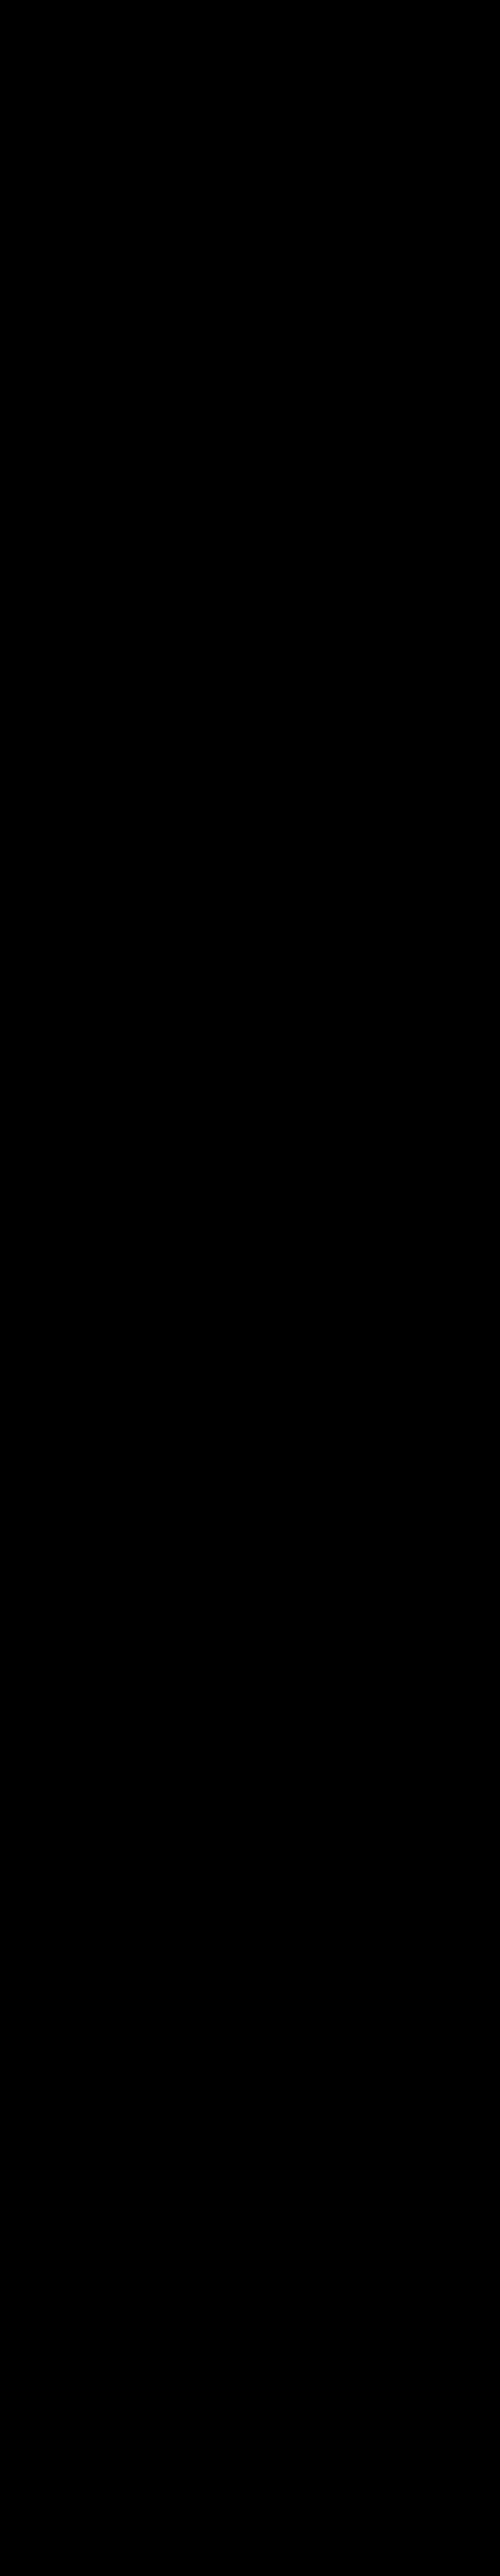
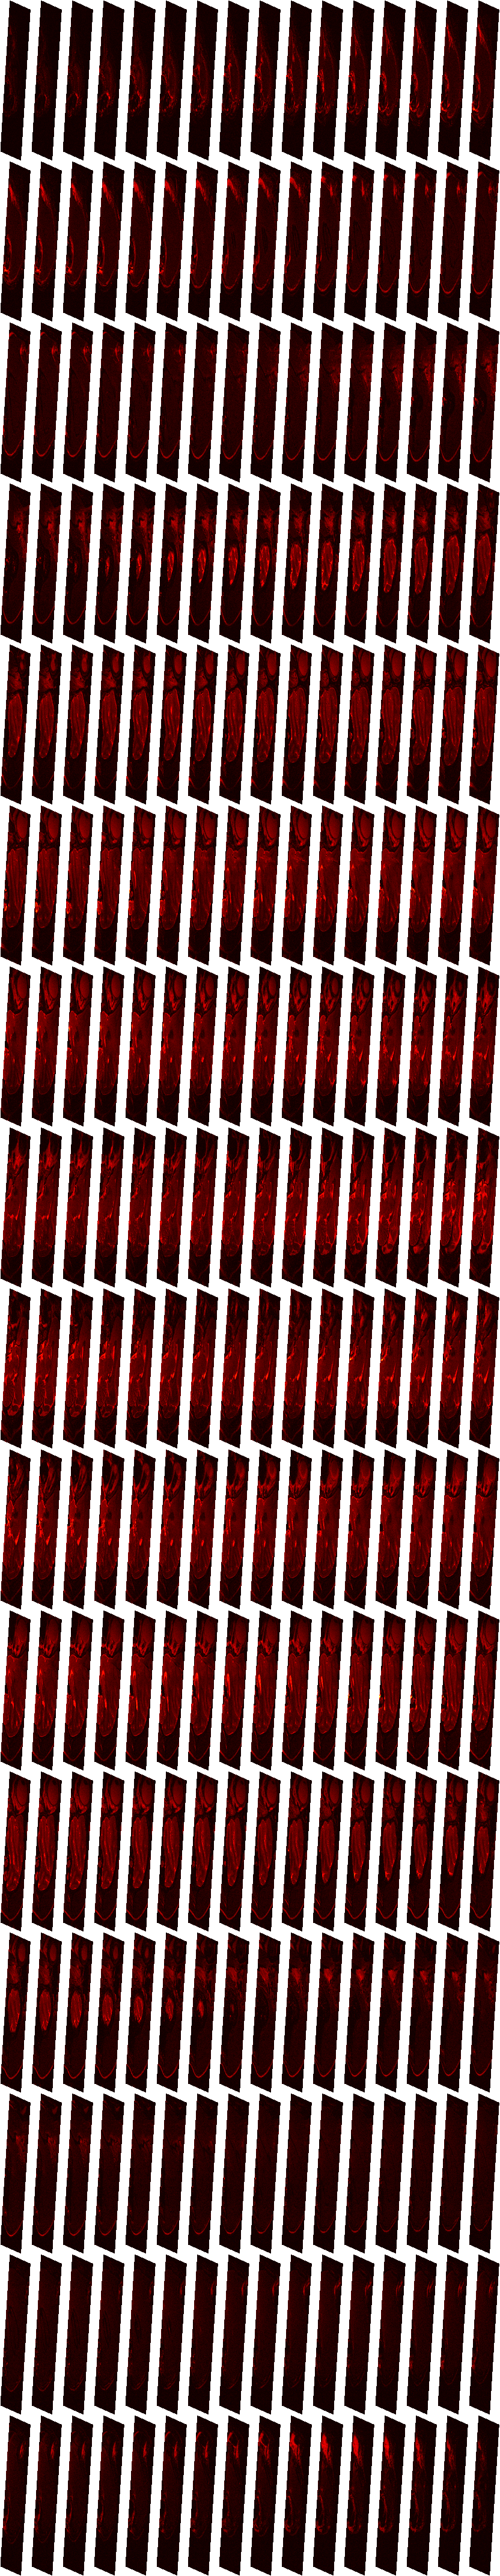

In [68]:
ax_anat = plotting.view_img(anat_filename, bg_img=False, colorbar=False, black_bg=True, threshold=None)
ax_anat.resize(1050, 450)

In [69]:
func_data = image.load_img(func_filename)
mean_data = image.mean_img(func_data)

To plot the EPI :

ax_func = plotting.view_img(mean_data, bg_img=False, colorbar=False, black_bg=True, threshold=None)
ax_func.resize(1050, 550)

In [70]:
def read_h5(filename: str):
    with h5py.File(filename, "r") as file:
        data = list(file['data'])
    
        meta = {}
        for key in file.attrs.keys():
            meta[key] = file.attrs[key][0]

    return data, meta

In [71]:
elec_data, meta = read_h5(elec_filename)

In [72]:
start = 0
stop = len(elec_data[0]) / meta['scan_rate_hz']
step = 1 / meta['scan_rate_hz']

elec_time = np.arange(start, stop, step)

In [73]:
events = pd.read_csv(event_filename) 
events['onset'] = events['onset']
events['duration'] = events['duration']

In [74]:
info_data =  pd.read_csv(info_filename) 
t_r = float(info_data[info_data['parameter'] == '-InterVolumeTime (ms)']['value'].iloc[0]) / 1000

In [75]:
fmri_glm = FirstLevelModel(
    t_r=t_r, # func_data.header['dim'][4] / events.shape[0],
    noise_model="ar1",
    standardize=False,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
    smoothing_fwhm=3,
)

In [76]:
fmri_glm = fmri_glm.fit(func_data, events)

In [77]:
design_matrix = fmri_glm.design_matrices_[0]

Text(0.5, 1.0, 'Expected Response')

<Figure size 640x480 with 0 Axes>

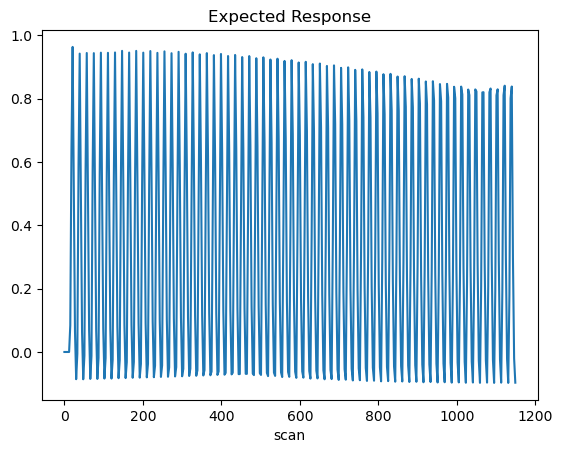

In [78]:
plt.close()
plt.cla()
plt.clf()

fig, ax = plt.subplots(1, 1)
ax.plot(design_matrix['active'])
ax.set_xlabel("scan")
ax.set_title("Expected Response")

The design matrix can be visualized in the following way if necessary:
`
plotting.plot_design_matrix(design_matrix)
plt.show()
`

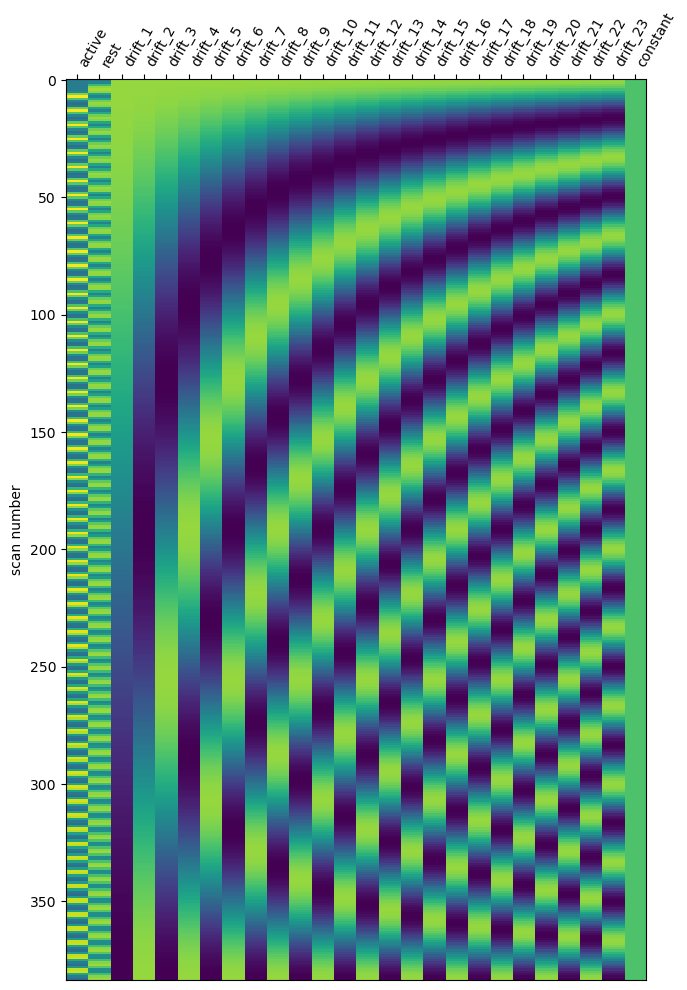

In [79]:
plotting.plot_design_matrix(design_matrix) 
plt.show()

In [80]:
n_conditions = design_matrix.shape[1]
conditions = {"active": np.zeros(n_conditions), "rest": np.zeros(n_conditions)}
conditions["rest"][0] = 1
conditions["active"][1] = 1

In [81]:
active_minus_rest = conditions["active"] - conditions["rest"]

<Axes: label='conditions'>

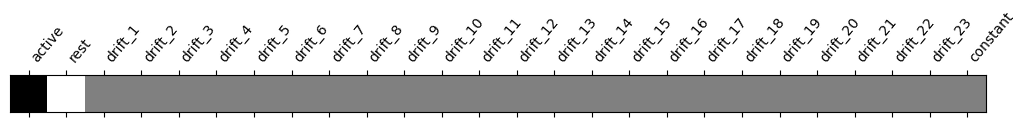

In [82]:
from nilearn.plotting import plot_contrast_matrix

plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)

In [83]:
eff_map = fmri_glm.compute_contrast(
    active_minus_rest, output_type="effect_size"
)

In [84]:
z_map = fmri_glm.compute_contrast(active_minus_rest, output_type="z_score")

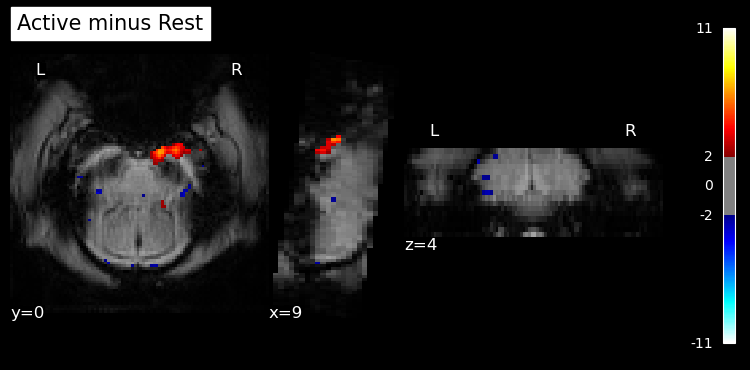

In [85]:
plotting.plot_stat_map(
    z_map,
    bg_img=mean_data,
    cut_coords = [9, 0, 4],
    threshold=2,
    black_bg=True,
    draw_cross=False,
    title="Active minus Rest",
)
plt.show()

C:\Users\carst\anaconda3\envs\fmri\lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



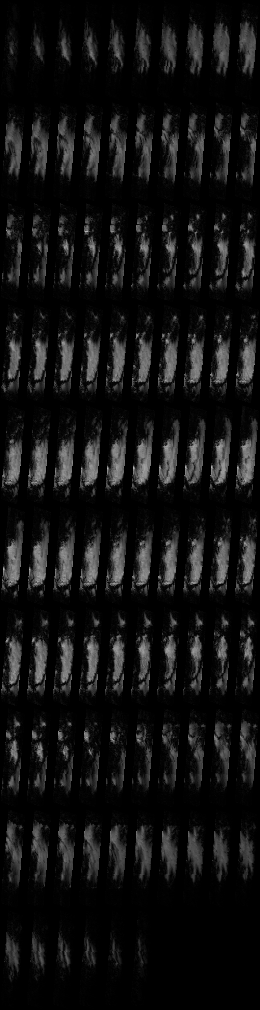
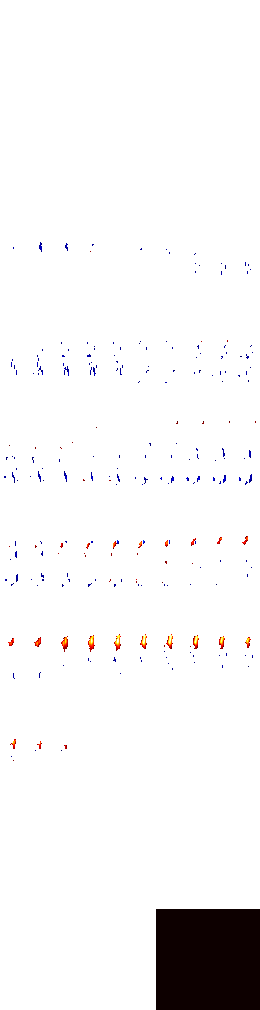

In [86]:
ax_stat = plotting.view_img(
    stat_map_img=z_map, 
    threshold=2,
    cut_coords = [9, 5, 4],
    bg_img=mean_data,      
    title="Activation Map")

ax_stat.resize(1050, 550)

In [87]:
print(func_data.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  96  96  18 384   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.   1.   1.   2.   0.75 1.   1.   1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : alternating decreasing
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : b'EPI_NATURE:ACQ_BRUKER_PVM'
aux_file        : b''
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       :